In [3]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model

from sklearn.metrics import confusion_matrix, classification_report

In [4]:
train_dir= Path('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test_dir = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val_dir  = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

In [5]:
path_train = list(train_dir.glob(r'*/*.jpeg'))
path_test = list(test_dir.glob(r'*/*.jpeg'))
path_val = list(val_dir.glob(r'*/*.jpeg'))

**Change var names here**

In [6]:
label_train = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], path_train))
label_test = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], path_test))
label_val = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], path_val))

In [7]:
x = path_train[0]
d = os.path.split(x)
print(d[1])

person1180_virus_2010.jpeg


In [8]:
images_train = pd.Series(path_train, name = "image").astype("str")
images_test = pd.Series(path_test, name = "image").astype("str")
images_val = pd.Series(path_val, name = "image").astype("str")

**Change var names here**

In [9]:
label_t = pd.Series(label_train, name = "label")
label_te = pd.Series(label_test, name = "label")
label_v = pd.Series(label_val, name = "label")

In [10]:
train_df = pd.concat([images_train, label_t], axis = 1)

In [11]:
train_df.head()

,image,label
0,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
1,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA


In [12]:
test_df = pd.concat([images_test, label_te], axis = 1)

In [13]:
test_df.head()

,image,label
0,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
1,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA


In [14]:
val_df = pd.concat([images_val, label_v], axis = 1)

In [15]:
val_df.head()

,image,label
0,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
1,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA


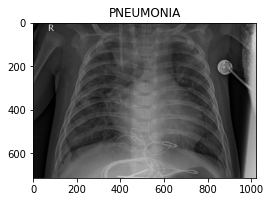

In [16]:
from keras.preprocessing.image import img_to_array, load_img
plt.figure(figsize = (4, 4))
img = load_img(train_df["image"][0])
plt.imshow(img)

plt.title(train_df["label"][0], size = 12)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

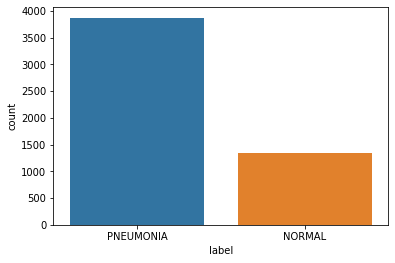

In [17]:
sns.countplot(train_df["label"])

In [18]:
b_size = 64
train_datagen = ImageDataGenerator(samplewise_center = True,
                                  samplewise_std_normalization = True)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                   shuffle = True,
                                                   target_size = (150, 150),
                                                   batch_size = b_size,
                                                   x_col = "image",
                                                   y_col = "label",
                                                   class_mode = "binary")

Found 5216 validated image filenames belonging to 2 classes.


In [19]:
val_datagen = ImageDataGenerator()

val_generator = val_datagen.flow_from_dataframe(dataframe = val_df,
                                               shuffle = True,
                                               target_size = (150, 150),
                                                batch_size = 1,
                                               x_col = "image",
                                               y_col = "label",
                                               class_mode = "binary")

Found 16 validated image filenames belonging to 2 classes.


In [20]:
test_generator = val_datagen.flow_from_dataframe(dataframe = test_df,
                                                shuffle = False,
                                                target_size = (150, 150),
                                                batch_size = b_size // 2,
                                                x_col = "image",
                                                y_col = "label",
                                                class_mode = "binary")

Found 624 validated image filenames belonging to 2 classes.


In [21]:
base_model = DenseNet121(weights = "imagenet", include_top = False)

29089792/29084464 [==============================] - 0s 0us/step


In [34]:
x= base_model.output
x= GlobalAveragePooling2D()(x)
predictions= Dense(units= 1, activation ="sigmoid")(x)

model= Model(inputs= base_model.input, outputs=predictions )

model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [35]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [44]:
history = model.fit(train_generator,
                    epochs= 5,
                    validation_data=val_generator,
                    steps_per_epoch=100,
                    validation_steps=2)

Epoch 1/5
100/100 [==============================] - 217s 2s/step - loss: 0.1272 - accuracy: 0.9503 - val_loss: 15.3514 - val_accuracy: 0.0000e+00


In [45]:
model.evaluate(val_generator)

16/16 [==============================] - 1s 63ms/step - loss: 7.3850 - accuracy: 0.5000


[7.385003089904785, 0.5]

In [42]:
results = model.evaluate(test_generator)
results

20/20 [==============================] - 25s 1s/step - loss: 3.9012 - accuracy: 0.6250


[3.901165008544922, 0.625]

In [43]:
print("The Loss on the test set is: {:.3f}".format(results[0]))
print("The accuracy on the test set is: {:.1f}%".format(results[1]*100))

The Loss on the test set is: 3.901
The accuracy on the test set is: 62.5%
